# Flood Detection using Deep Learning (Finetuning MobileNet, KERAS)

In [2]:
import os
import shutil
import random
import itertools
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from keras import backend
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Activation
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import decode_predictions, preprocess_input

In [4]:
labels = ['Flooding', 'No Flooding']
train_path = 'data/train'
valid_path = 'data/valid'
test_path = 'data/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 321 images belonging to 2 classes.
Found 81 images belonging to 2 classes.
Found 71 images belonging to 2 classes.


In [5]:

mobile = tf.keras.applications.mobilenet.MobileNet()

17235968/17225924 [==============================] - 2s 0us/step


In [6]:
# last 5 layers of the mobilenet during finetuning as we want 
x = mobile.layers[-6].output

In [7]:

output = Dense(units=2, activation='softmax')(x)

In [8]:

model = Model(inputs=mobile.input, outputs=output)

In [9]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [11]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\Ojas Karmarkar\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [12]:
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=10,
          verbose=2
)

Epoch 1/10


C:\Python39\lib\site-packages\PIL\Image.py:973: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


33/33 - 15s - loss: 0.3701 - accuracy: 0.8442 - val_loss: 0.1099 - val_accuracy: 0.9383
Epoch 2/10
33/33 - 11s - loss: 0.0735 - accuracy: 0.9782 - val_loss: 0.0785 - val_accuracy: 0.9877
Epoch 3/10
33/33 - 11s - loss: 0.0783 - accuracy: 0.9782 - val_loss: 0.0653 - val_accuracy: 0.9877
Epoch 4/10
33/33 - 11s - loss: 0.0291 - accuracy: 0.9969 - val_loss: 0.0830 - val_accuracy: 0.9753
Epoch 5/10
33/33 - 11s - loss: 0.0299 - accuracy: 0.9938 - val_loss: 0.1214 - val_accuracy: 0.9506
Epoch 6/10
33/33 - 11s - loss: 0.0359 - accuracy: 0.9907 - val_loss: 0.1212 - val_accuracy: 0.9383
Epoch 7/10
33/33 - 11s - loss: 0.0369 - accuracy: 0.9907 - val_loss: 0.3732 - val_accuracy: 0.8642
Epoch 8/10
33/33 - 11s - loss: 0.0203 - accuracy: 0.9938 - val_loss: 0.2657 - val_accuracy: 0.9012
Epoch 9/10
33/33 - 10s - loss: 0.0653 - accuracy: 0.9751 - val_loss: 0.2265 - val_accuracy: 0.9012
Epoch 10/10
33/33 - 10s - loss: 0.0186 - accuracy: 0.9969 - val_loss: 0.0956 - val_accuracy: 0.9383


In [13]:
# Saving and loading our trained for future use

model.save("model.h5")
# model.load_weights('fine_tuned_flood_detection_model')

In [14]:
# Make predictions and plot confusion matrix to look how well our model performed in classifying 
# flooding and no flooding images 

test_labels = test_batches.classes
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
precision = precision_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
f1_score = f1_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
accuracy = accuracy_score(y_true=test_labels, y_pred=predictions.argmax(axis=1))
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
# Pring precision, F1 score and accuracy of our model
print('Precision: ', precision)
print('F1 Score: ', f1_score)
print('Accuracy: ', accuracy)

Precision:  0.8484848484848485
F1 Score:  0.9180327868852458
Accuracy:  0.9295774647887324


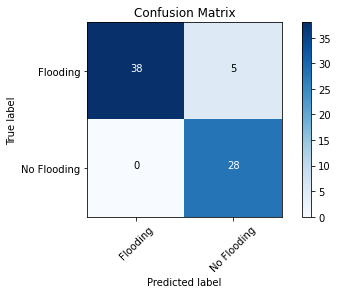

In [16]:
# Confusion Matrix 
test_batches.class_indices
cm_plot_labels = ['Flooding','No Flooding']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## Evaluate our finetuned model

In [62]:
# Prepare image for mobilenet prediction

def preprocess_image(file):
    img_path = 'evaluate/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

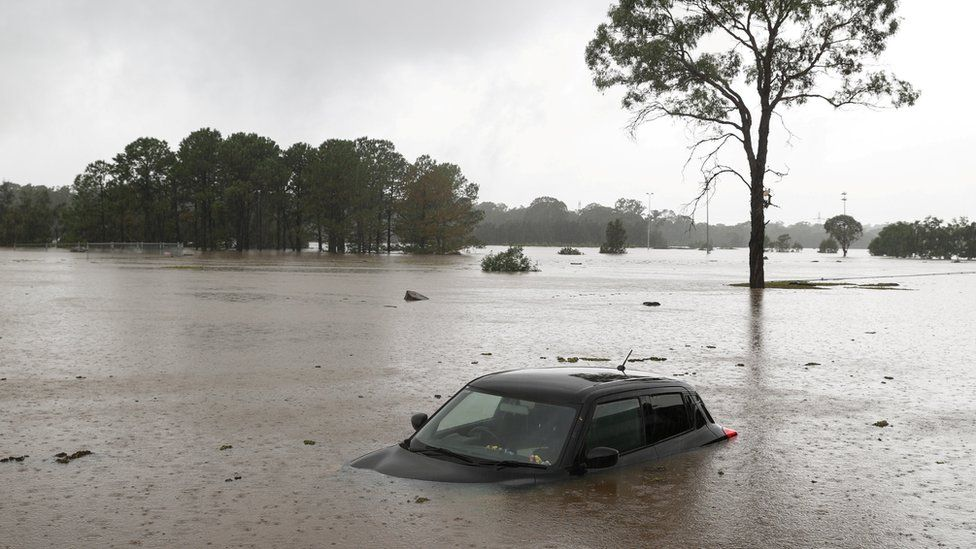

In [63]:
# Display image which we want to predict
from IPython.display import Image
Image(filename='evaluate/30.jpg', width=300,height=200) 

In [67]:
preprocessed_image = preprocess_image('30.jpg')
predictions = model.predict(preprocessed_image)

In [58]:
predictions

array([[0.9923564 , 0.00764361]], dtype=float32)

In [59]:
result = np.argmax(predictions)

In [60]:
labels[result]

'Flooding'

NOTE, This code was inspired and modified from the following source: 
https://deeplizard.com/.


Flooding images were collected from paper named "Detecting floodwater on roadways from image data with handcrafted features and deep transfer learning*", available at "https://arxiv.org/pdf/1909.00125.pdf". 

Funfact: This model outperforms the model presented in the paper.

Normal or No Flooding images were collected from google image search, there may be irrelevant images in this category
because the images were downloaded using an automated script. 

The trained model performed quite impressively and got an accuracy score of over 98%.

In [61]:
# import tensorflow as tf

# model = tf.keras.models.load_model('model.h5')
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()
# open("converted_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\OJASKA~1\AppData\Local\Temp\tmp3_cajyaj\assets


12807944